__Import the required modules__

In [1]:
#NLP Modules
import spacy
nlp = spacy.load('en_core_web_sm')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import enchant
d = enchant.Dict("en_UK")

import urllib

#Statistics Modules
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import coo_matrix
import random

__Read the text file__

In [2]:
fp = open('./Text Files/fess103_txt.txt', 'r')
text = str(fp.read())
fp.close()

__Extract custom stop words__

In [3]:
#Stop-words are the words most common words in any language. eg: the, is,on. These need to be filtered out.
#Spacy has an in built corpus of stop words.
#In addition to this, it is important to filter out some dataset specific stop-words.

word_count = {}                                               #Dictionary to hold the frequencies of every word.
for word in text.split():
    if word.lower() in word_count.keys():
        word_count[word.lower()] +=1
    else:
        word_count[word.lower()] = 1


frequencies = [v for v in word_count.values()]
threshold = np.percentile(frequencies, 95)                   #Threshold frequency is chosen as the 95th percentile

#Creating custom stop-words list
s_w = ['chapter', 'ncert', 'class', 'years', 'year',         #Basic stop-words for a textbook
       'thousand', 'notice', 'list', 'suggest', 'men', 'women', 'page', 'example']    

#Also add: east, west, north, south?

for k, v in word_count.items():
    if v>threshold:
        if not nlp.vocab[k].is_stop:                         #Check is the word isn't a pre-existing stop word
            s_w.append(k)

def custom_stop_words(word):                                 #Function to add to the default stop words
    if not nlp.vocab[word].is_stop:
        nlp.Defaults.stop_words.add(word)
        nlp.vocab[word].is_stop = True

for word in s_w:
    custom_stop_words(word)
    
print("STOP WORDS ADDED:", s_w, sep = '\n')

STOP WORDS ADDED:
['chapter', 'ncert', 'class', 'years', 'year', 'thousand', 'notice', 'list', 'suggest', 'men', 'women', 'page', 'example', 'buildings', 'years', 'archaeologists', 'found', 'cities', 'stone', 'probably', 'people', 'harappan', 'men', ':', 'find', 'languages']


__Split the chapter into sections__

In [4]:
text_ = text.split("\n\n")
text_ = [each.replace('\n', ' ') for each in text_]                    #Method : A section header does not end with a punctuation
                                                                       #and is followed by \n\n
    
index = 0
section_text = [""]                                                    #List to hold section text
section_headers = []                                                   #List to hold section headers
for para in text_:
    if nlp.vocab[para[-1]].is_punct or ':' in para:
        section_text[index] += " " +para
    else:
        if(len(para) < 50 and len(para) > 4 and para[0].isupper()):    #Little text paragraphs are ignored as they desc images
            if not section_text[index] == "":
                index +=1
                section_text.append(para + '.')
            else:
                section_text[index] += para
            section_headers.append(para)
        else:
            section_text[index] += " " + para

print("NUMBER OF SECTIONS:",len(section_headers), sep = '\n')

NUMBER OF SECTIONS:
20


In [5]:
#The first section created includes the heading, with words that'll recur through all sections, and hence, can be removed.
#They are added on as stop words

more_sw = []
for i in nlp(" ".join(section_text[0].split())):
    word = i.lemma_
    if len(word)>1:
        if not word in s_w:
            more_sw.append(word.lower())
            
section_text = [para for para in section_text if len(para)>50]  

for word in more_sw:
    custom_stop_words(word)

In [6]:
#List to contain all the keywords.To prevent the addition of pre-existing keywords.
nc_keyword_vocab = []
keyword_vocab = []

### 1. Extraction of noun chunks from each section

In [7]:
noun_chunks = {}

def find_nchunks(section):
    chunks = []                                                             #List of all the noun chunks in a section
    for chunk in section.noun_chunks:
        chunks.append(nlp(chunk.text))
        
    filtered_chunks = []                                                    #List of partially processed and filtered chunks
    for chunk in chunks:
        chunk_new = ""
        for word in chunk:
            word_ = nlp.vocab[word.lemma_]                                  #Filter conditions
            if len(word_.text) > 3:                                         #Word length > 3
                if not word_.text in nc_keyword_vocab:                      #Word hasn't already been mentioned in a n chunk
                    if not word_.is_stop:                                   #Not a stop word
                        if not word_.text == '-PRON-':                      #Not a pronoun
                            if nlp.vocab[word_.text].is_alpha:              #Not numeric/with junk characters
                                if not word.pos in [84, 85, 89, 90, 100]:   #ADP, ADV, DET, NotDef, INTJ
                                    if not chunk_new == "":
                                        chunk_new += " "
                                    chunk_new += word.text
                
        if (len(chunk_new.split())) <4:                    
            if not chunk_new == "" and chunk_new not in filtered_chunks:                     #Avoiding rep of chunks within section
                filtered_chunks.append(chunk_new)
                nc_keyword_vocab.extend([nlp(word)[0].lemma_ for word in chunk_new.split()]) #Adds words in chunks to the keyword vocab
    
    return filtered_chunks

index = 1
for para in section_text:
    noun_chunks['Section ' + str(index)] = list(set(find_nchunks(nlp(para))))
    index += 1
            
print((noun_chunks['Section 1']))

['engineers', 'time', 'Harappa', 'Lothal', 'construction', 'larger', 'things', 'special', 'natural', 'Kalibangan', 'sseronslap houses', 'copper tool', 'beads', 'drained', 'steps', 'Hatappa', 'occasions', 'subcontinent', 'archaeologists', 'plaster', 'mound', 'buildings', 'Pakistan', 'layer', 'rich source', 'west', 'similar', 'rooms', 'railway lines', 'Punjab', 'Water', 'fire altars', 'citadel', 'tank', 'interlocking pattern', 'baked', 'site', 'ARABIAN', 'Mohenjodaro', 'high quality bricks', 'Gujarat', 'sacrifices', 'unque object', 'story', 'Notte Great Bath', 'Sind', 'important', 'elaborate store', 'smaller fesshon Horyanaane', 'walls', 'east', 'area', 'city']


### 2. Extraction of keywords from each section.

__Add named entities to raw keyword list__

In [8]:
doc = [nlp(section) for section in section_text]

def create_ent_list(section):
    ent_list = set([(ent.text).lower() for ent in section.ents if not ent.label_ in ["ORDINAL", "CARDINAL"]
                    and nlp((ent.text))[0].lemma_ not in nc_keyword_vocab
                    and nlp.vocab[ent.text].is_alpha 
                    and not nlp.vocab[(ent.text).lower()].is_stop
                    and len((ent.text).split())<2
                    and len(ent.text)>3])
    
    keyword_vocab.extend(ent_list)
    return ent_list

#Create a dictionary to hold keywords to demarcate sections.
#Later, will have the key-value pairs section segmented.

raw_keywords = {}  
index = 1
for i in doc:
    raw_keywords["Section " + str(index)] = list(create_ent_list(i))
    index += 1
    
print(raw_keywords['Section 9'])

['match', 'greek', 'german', 'french', 'italian', 'indo']


__Pre-Processing the text__

In [9]:
def preprocess(text):

    # 1. Removing punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)

    # 2. Convert to lower case
    text = text.lower()

    # 3. Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # 4. Remove special characters
    text = re.sub("(\W)+", " ", text)

    # 5. Convert to list
    text = text.split()
    return text

index = 0
for text in section_text:
    section_text[index] = preprocess(text)
    index += 1

index = 0
for header in section_headers:
    section_headers[index] = " ".join(preprocess(header))
    index += 1

print('PRE-PROCESSED TEXT:', section_text[0][:20], sep = '\n')

PRE-PROCESSED TEXT:
['the', 'story', 'of', 'hatappa', 'very', 'often', 'old', 'buildings', 'have', 'a', 'story', 'to', 'tell', 'nearly', 'a', 'hundred', 'and', 'fifty', 'years', 'ago']


In [10]:
print(section_headers)

['the story of hatappa', 'houses drains and streets', 'new crafts in the city', 'in search of raw materials', 'food for people in the cities', 'a closer look harappan towns in gujarat', 'the mystery of the end', 'elsewhere', 'imagine', 'how historians study the rigveda', 'cattle horses and chariots', 'words to describe people', 'silent sentinels the story of the megaliths', 'a special burial at namgaon', 'what skeletal studies tell us', 'occupations at inamgaon', 'elsewhere', 'imagine', 'name work vanguage', 'anything else']


_Lemmatization_

In [11]:
#Lemmatization

lemmatized_list = []

for section in doc:
    l = []
    for token in section:
        l.append(token.lemma_)
    lemmatized_list.append(l)
    
print("LEMMATIZED TEXT:", lemmatized_list[0][:20], sep = '\n')

LEMMATIZED TEXT:
['the', 'story', 'of', 'hatappa', '.', 'very', 'often', ',', 'old', 'building', 'have', 'a', 'story', 'to', 'tell', '.', 'nearly', 'a', 'hundred', 'and']


_Removing stop words_

In [12]:
filtered_list = []

for section in lemmatized_list:
    section = nlp(" ".join(section))
    l = []
    for token in section:
        if not token.is_stop:
            if not token.is_punct:
                if not token.text == '-PRON-':
                    l.append(token.text)
    filtered_list.append(l)

print("FILTERED TEXT:", filtered_list[0][:20], sep = '\n')

FILTERED TEXT:
['story', 'hatappa', 'old', 'building', 'story', 'tell', 'nearly', 'ago', 'railway', 'line', 'lay', 'time', 'punjab', 'engineer', 'stumble', 'site', 'harappa', 'present', 'day', 'pakistan']


### 3. Text Feature Extraction

__Preliminary Data Exploration__

             Word  Freq
0            city    33
1             use    30
2            know    16
3             ago    14
4        describe    13
5           river    13
6          burial    13
7        language    13
8         rigveda    13
9        building    12
10          large    12
11          house    12
12            man    12
13  archaeologist    11
14           bead    11
15          water    11
16          place    11
17          write    11
18           bury    11
19         family    11


C:\Users\manah\.conda\envs\nlp_course\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pasts'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[Text(0, 0, 'city'),
 Text(0, 0, 'use'),
 Text(0, 0, 'know'),
 Text(0, 0, 'ago'),
 Text(0, 0, 'describe'),
 Text(0, 0, 'river'),
 Text(0, 0, 'burial'),
 Text(0, 0, 'language'),
 Text(0, 0, 'rigveda'),
 Text(0, 0, 'building'),
 Text(0, 0, 'large'),
 Text(0, 0, 'house'),
 Text(0, 0, 'man'),
 Text(0, 0, 'archaeologist'),
 Text(0, 0, 'bead'),
 Text(0, 0, 'water'),
 Text(0, 0, 'place'),
 Text(0, 0, 'write'),
 Text(0, 0, 'bury'),
 Text(0, 0, 'family')]

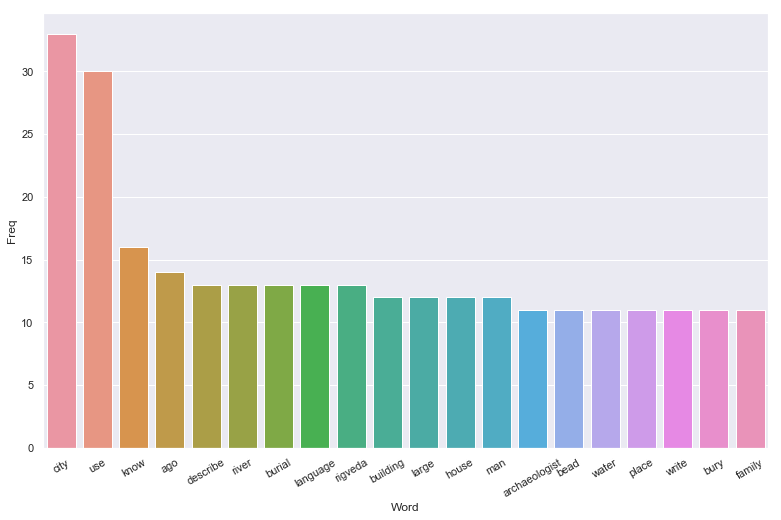

In [13]:
l = []                                                          #Create a list of all the words
for section in filtered_list:
    for word in section:
        l.append(word)

    
count_vector = CountVectorizer(max_df = 0.8, stop_words = nlp.Defaults.stop_words,
                               max_features = 10000, ngram_range = (1,3))
x = count_vector.fit_transform(l)

#Most frequently occuring words

def get_top_n_words(text, n = None):
    vec = CountVectorizer().fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

top_words = get_top_n_words(l, n=20)

#Convert to datframe for plotting
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

#Plotting n-grams - Mono
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


              Bi-gram  Freq
0        raw material     7
1         present day     6
2        old building     5
3         gold silver     5
4           man woman     4
5       farmer herder     4
6      language speak     4
7       building city     3
8           live city     3
9   look illustration     3
10      reason answer     3
11    family language     3
12      belong family     3
13      describe term     3
14          term work     3
15      work language     3
16          jana vish     3
17       railway line     2
18       day pakistan     2
19          city city     2


[Text(0, 0, 'raw material'),
 Text(0, 0, 'present day'),
 Text(0, 0, 'old building'),
 Text(0, 0, 'gold silver'),
 Text(0, 0, 'man woman'),
 Text(0, 0, 'farmer herder'),
 Text(0, 0, 'language speak'),
 Text(0, 0, 'building city'),
 Text(0, 0, 'live city'),
 Text(0, 0, 'look illustration'),
 Text(0, 0, 'reason answer'),
 Text(0, 0, 'family language'),
 Text(0, 0, 'belong family'),
 Text(0, 0, 'describe term'),
 Text(0, 0, 'term work'),
 Text(0, 0, 'work language'),
 Text(0, 0, 'jana vish'),
 Text(0, 0, 'railway line'),
 Text(0, 0, 'day pakistan'),
 Text(0, 0, 'city city')]

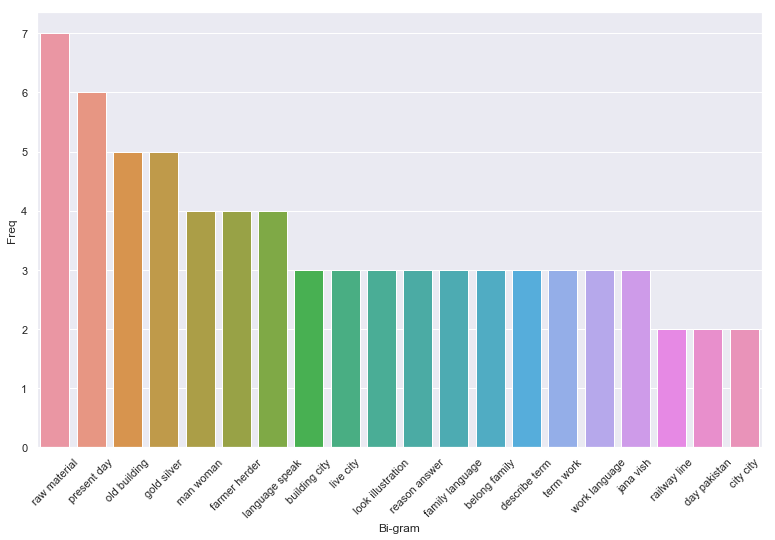

In [14]:
f_l = []                                                                               #List of all the sections
for i in range(len(filtered_list)):
    f_l.append(" ".join(filtered_list[i]))
    
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(f_l, n=20)

top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)


                   Tri-gram  Freq
0        describe term work     3
1       work language speak     3
2      present day pakistan     2
3         cattle sheep goat     2
4        term work language     2
5         word use describe     2
6         story hatappa old     1
7      hatappa old building     1
8        old building story     1
9       building story tell     1
10        story tell nearly     1
11          tell nearly ago     1
12       nearly ago railway     1
13         ago railway line     1
14         railway line lay     1
15            line lay time     1
16          lay time punjab     1
17     time punjab engineer     1
18  punjab engineer stumble     1
19    engineer stumble site     1


[Text(0, 0, 'describe term work'),
 Text(0, 0, 'work language speak'),
 Text(0, 0, 'present day pakistan'),
 Text(0, 0, 'cattle sheep goat'),
 Text(0, 0, 'term work language'),
 Text(0, 0, 'word use describe'),
 Text(0, 0, 'story hatappa old'),
 Text(0, 0, 'hatappa old building'),
 Text(0, 0, 'old building story'),
 Text(0, 0, 'building story tell'),
 Text(0, 0, 'story tell nearly'),
 Text(0, 0, 'tell nearly ago'),
 Text(0, 0, 'nearly ago railway'),
 Text(0, 0, 'ago railway line'),
 Text(0, 0, 'railway line lay'),
 Text(0, 0, 'line lay time'),
 Text(0, 0, 'lay time punjab'),
 Text(0, 0, 'time punjab engineer'),
 Text(0, 0, 'punjab engineer stumble'),
 Text(0, 0, 'engineer stumble site')]

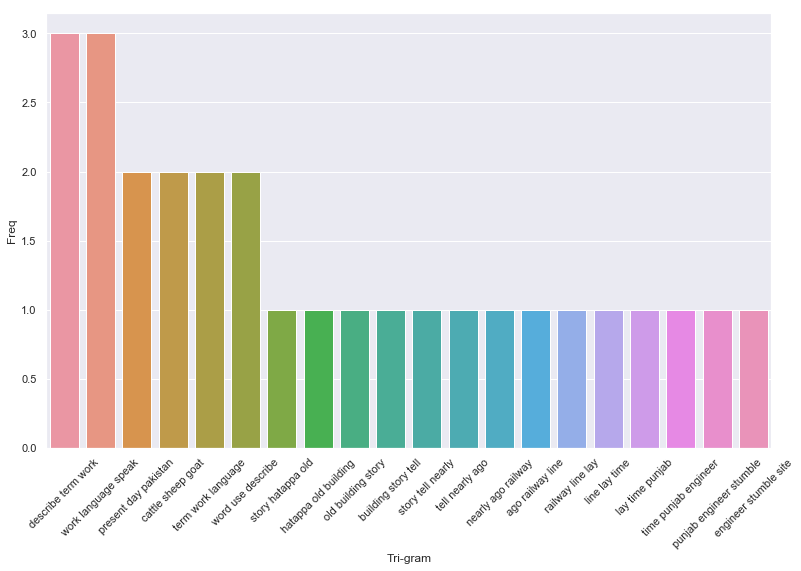

In [15]:
#Most frequently occuring Tri-grams

def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top3_words = get_top_n3_words(f_l, n=20)

top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams

sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)


__Keyword Extraction using tf-idf method__

In [16]:
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(x)

feature_names = count_vector.get_feature_names()                  #Get feature names
docs = []                                                         #Fetch sections from which keywords needs to be extracted
for i in range(len(filtered_list)):
    docs.append(" ".join(filtered_list[i]))
                                                                  
        
def sort_coo(coo_matrix):                                                #Generate tf-idf for the given document
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):      #Feature names and tf-idf scores for top n items
    
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    for idx, score in sorted_items:                                      #word index and corresponding tf-idf score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results= {}                                                           #create tuples of feature,score and store in dict
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

index = 1
for doc in docs:
    keywords = []
    tf_idf_vector = tfidf_transformer.transform(count_vector.transform([doc]))
    sorted_items = sort_coo(tf_idf_vector.tocoo())                                #sort the tf-idf vectors by descending order of scores

    keywords = extract_topn_from_vector(feature_names,sorted_items,10)
    
    for k in set(keywords):
        if (len(k)>3) and (k not in nc_keyword_vocab):                            #Avoid addition of words part of existing n_chunk
            if k not in keyword_vocab:                                            #Avoid addition of words part of another section/same section
                if not nlp(k)[0].is_stop:
                    keyword_vocab.append(k)
                    raw_keywords['Section ' + str(index)].append(k)
            else:                                                                 #Remove the word from the other section too, to avoid multiple relations.
                keyword_vocab.remove(k)
                for i in range(1, index):
                    if k in raw_keywords['Section ' + str(i)]:
                        raw_keywords['Section ' + str(i)].remove(k)
    
    index += 1
    
print((raw_keywords['Section 2']))
print(section_headers[1])

['plan']
houses drains and streets


_Pre-Process noun chunks_

In [17]:
#preprocess() takes string as input and returns a word.

for section, text in noun_chunks.items():
    l = []
    for word in text:
        new_word = preprocess(word)
        l.append(" ".join(new_word))
    noun_chunks[section] = l
        
#noun_chunks['Section 3']

In [18]:
#Final raw keywords list.

for k in raw_keywords:
    raw_keywords[k] += noun_chunks[k]

In [19]:
print(section_headers[2], raw_keywords['Section 3'], sep = '\n\n')

new crafts in the city

['carve', 'beard', 'vase', 'black designs', 'beena', 'thread', 'bronze', 'everybody', 'harappans', 'polishing', 'weapons', 'expert', 'illustration', 'rumade', 'animal', 'actual pieces', 'striking', 'vessels', 'work', 'spindle whorls', 'cotton', 'face', 'specialists', 'faience']


In [20]:
final_sections = {}
index = 0
for section, words in raw_keywords.items():
    if not section_headers[index] == 'Imagine':
        if not len(words) < 15:
            final_sections[section_headers[index]] = words
    index+=1

In [21]:
#Filter out the noisy words that do not exist - keyphrase list + headers

def check_existence(section):
    l = []
    for word in section:
        flag = 1
        words = word.split()
        for w in words:
            try :
                url_text = "https://en.wikipedia.org/wiki/" + w            #Check existence against a wiki article
                urllib.request.urlopen(url_text).getcode()
            except :
                flag = 0
                break
        if (flag):
            l.append(word)
    return l

keyphrases = {}
for section, words in final_sections.items():     
    keyphrases[section] = check_existence(final_sections[section])

index = 0
for header in section_headers:
    section_headers[index] = " ".join(check_existence(header.split()))
    index += 1

In [22]:
#Print the section header with the set of keywords

for section, words in keyphrases.items():
    print(f'\n{section.upper()}:', words, sep = '\n')


THE STORY OF HATAPPA:
['build', 'engineers', 'time', 'harappa', 'lothal', 'construction', 'things', 'special', 'natural', 'kalibangan', 'copper tool', 'beads', 'drained', 'steps', 'occasions', 'subcontinent', 'archaeologists', 'plaster', 'mound', 'buildings', 'pakistan', 'layer', 'rich source', 'west', 'similar', 'rooms', 'railway lines', 'punjab', 'water', 'fire altars', 'citadel', 'tank', 'interlocking pattern', 'baked', 'site', 'arabian', 'mohenjodaro', 'high quality bricks', 'gujarat', 'sacrifices', 'story', 'notte great bath', 'sind', 'important', 'walls', 'east', 'area', 'city']

HOUSES DRAINS AND STREETS:
['plan', 'scholars', 'silver', 'intervals', 'workshops', 'materials', 'streets', 'carnelian', 'villages', 'gentle slope', 'valuable', 'chert', 'homes', 'kinds', 'ornaments', 'distant lands', 'metal', 'centre', 'separate bathing', 'courtyard', 'weights', 'garment', 'script', 'women', 'busy place', 'rulers', 'blades', 'crafts persons', 'seals', 'inspection holes', 'straight', 'd

In [33]:
section_list = random.sample(list(final_sections.keys()), k = 5)                  #Randomly select 5 questions

keyword_list = []                                                                 #List of all keywords
for section, words in final_sections.items():
    keyword_list += words
    
ans_clues = {}                                                                    #Dictionary with all the right answers
rand_words = {}                                                                   #Dictionary with the wrong answers
for i in range(5):
    ans_clues[section_list[i]] = random.sample(final_sections[section_list[i]],5)
    rand_words[section_list[i]] = random.sample([word for word in keyword_list                          #Add words not a clue to that particular section
                                                 if not word in final_sections[section_list[i]]], 20)

for section, words in ans_clues.items():                                          #Final output
    print(section.upper(), words, rand_words[section], sep = '\n')
    print('\n')

HOW HISTORIANS STUDY THE RIGVEDA
['axles', 'translation', 'hymns', 'dialogues', 'verses']
['animal', 'baking', 'school', 'seeds', 'beena', 'women', 'public ceremonies', 'burials', 'wild', 'drink', 'skilful warriors', 'thie funeral', 'social', 'drainage system', 'previous section', 'skeletal studies', 'gentle slope', 'guif', 'equipment', 'terms']


WHAT SKELETAL STUDIES TELL US
['distinctions', 'figure', 'cartilage', 'skeletal studies', 'jewellery']
['armies', 'blackbuck', 'green cover', 'thread', 'site', 'boulders', 'preserve', 'description', 'social', 'afghanistan', 'world history', 'build', 'tombs', 'summer months', 'beena', 'opponents', 'tome swift horses', 'writing', 'grass', 'fributary']


ELSEWHERE
['ivory', 'world history', 'tombs', 'clothes', 'musical instruments']
['dast', 'society', 'goode', 'long', 'drainage system', 'writing', 'metal', 'leaders', 'sage', 'modern anatomy', 'brahmins', 'fish', 'iron', 'harappans', 'jamun', 'mustard', 'portholes', 'scribes', 'sambhar', 'rann']

In [36]:
fp = open('output.txt', 'w')                           #Write the final output to a .txt file for website use
l = []
for section, words in ans_clues.items():
    fp.write(section.upper() + '\n' + str(words) + '\n' + str(rand_words[section])+'\n')
fp.close()